# MADE. RL and Advanced DL.
## Assignment 3. 
### GANs. Pix2Pix. CycleGAN.
#### Otabek Nazarov

In [1]:
# Imports

import torch
from utils import save_some_examples
import torch.nn as nn
import torch.optim as optim
from dataset import FacadesDataset
from p2p_generator_model import Generator as GeneratorP2P
from p2p_discriminator_model import Discriminator as DiscriminatorP2P
from cgan_discriminator_model import Discriminator as DiscriminatorCGAN
from cgan_generator_model import Generator as GeneratorCGAN
from torch.utils.data import DataLoader
from tqdm import tqdm

torch.backends.cudnn.benchmark = True

## Part 1. Pix2Pix.

- given some raw kind of input, transfers it to some other stylistic style
- generator: similar to U-Net; has downsampling, upsampling and skip connections
- discriminator: several convolutional layers to identify fake from real

In [4]:
# Configurations for Pix2Pix GAN

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_DIR = "facades/train"
VAL_DIR = "facades/val"
LEARNING_RATE = 2e-4
BATCH_SIZE = 16
NUM_WORKERS = 2
IMAGE_SIZE = 256
CHANNELS_IMG = 3
L1_LAMBDA = 100
LAMBDA_GP = 10
NUM_EPOCHS = 300

In [5]:
# Function to train Pix2Pix models

def train_p2p(disc, gen, loader, opt_disc, opt_gen, l1_loss, bce, g_scaler, d_scaler,):

    loop = tqdm(loader, leave=True)

    for idx, (x, y) in enumerate(loop):
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        # Train Discriminator
        with torch.cuda.amp.autocast():
            y_fake = gen(x)
            D_real = disc(x, y)
            D_real_loss = bce(D_real, torch.ones_like(D_real))
            D_fake = disc(x, y_fake.detach())
            D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
            D_loss = (D_real_loss + D_fake_loss) / 2

        disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train generator
        with torch.cuda.amp.autocast():
            D_fake = disc(x, y_fake)
            G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
            L1 = l1_loss(y_fake, y) * L1_LAMBDA
            G_loss = G_fake_loss + L1

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        if idx % 10 == 0:
            loop.set_postfix(D_real=torch.sigmoid(D_real).mean().item(), D_fake=torch.sigmoid(D_fake).mean().item())

In [ ]:
# Model training

## Model
disc = DiscriminatorP2P(in_channels=3).to(DEVICE)
gen = GeneratorP2P(in_channels=3, features=64).to(DEVICE)

## Optimizers
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

## Losses
BCE = nn.BCEWithLogitsLoss()
L1_LOSS = nn.L1Loss()

## Dataloaders
train_dataset = FacadesDataset(root_dir=TRAIN_DIR)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True,num_workers=NUM_WORKERS)
val_dataset = FacadesDataset(root_dir=VAL_DIR)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)

## Speeds up training
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

## Train model
for epoch in range(NUM_EPOCHS):
    train_p2p(disc, gen, train_loader, opt_disc, opt_gen, L1_LOSS, BCE, g_scaler, d_scaler)

    # Save example images
    if epoch % 5 == 0:
        save_some_examples(gen, val_loader, epoch, folder="evaluation_p2p")

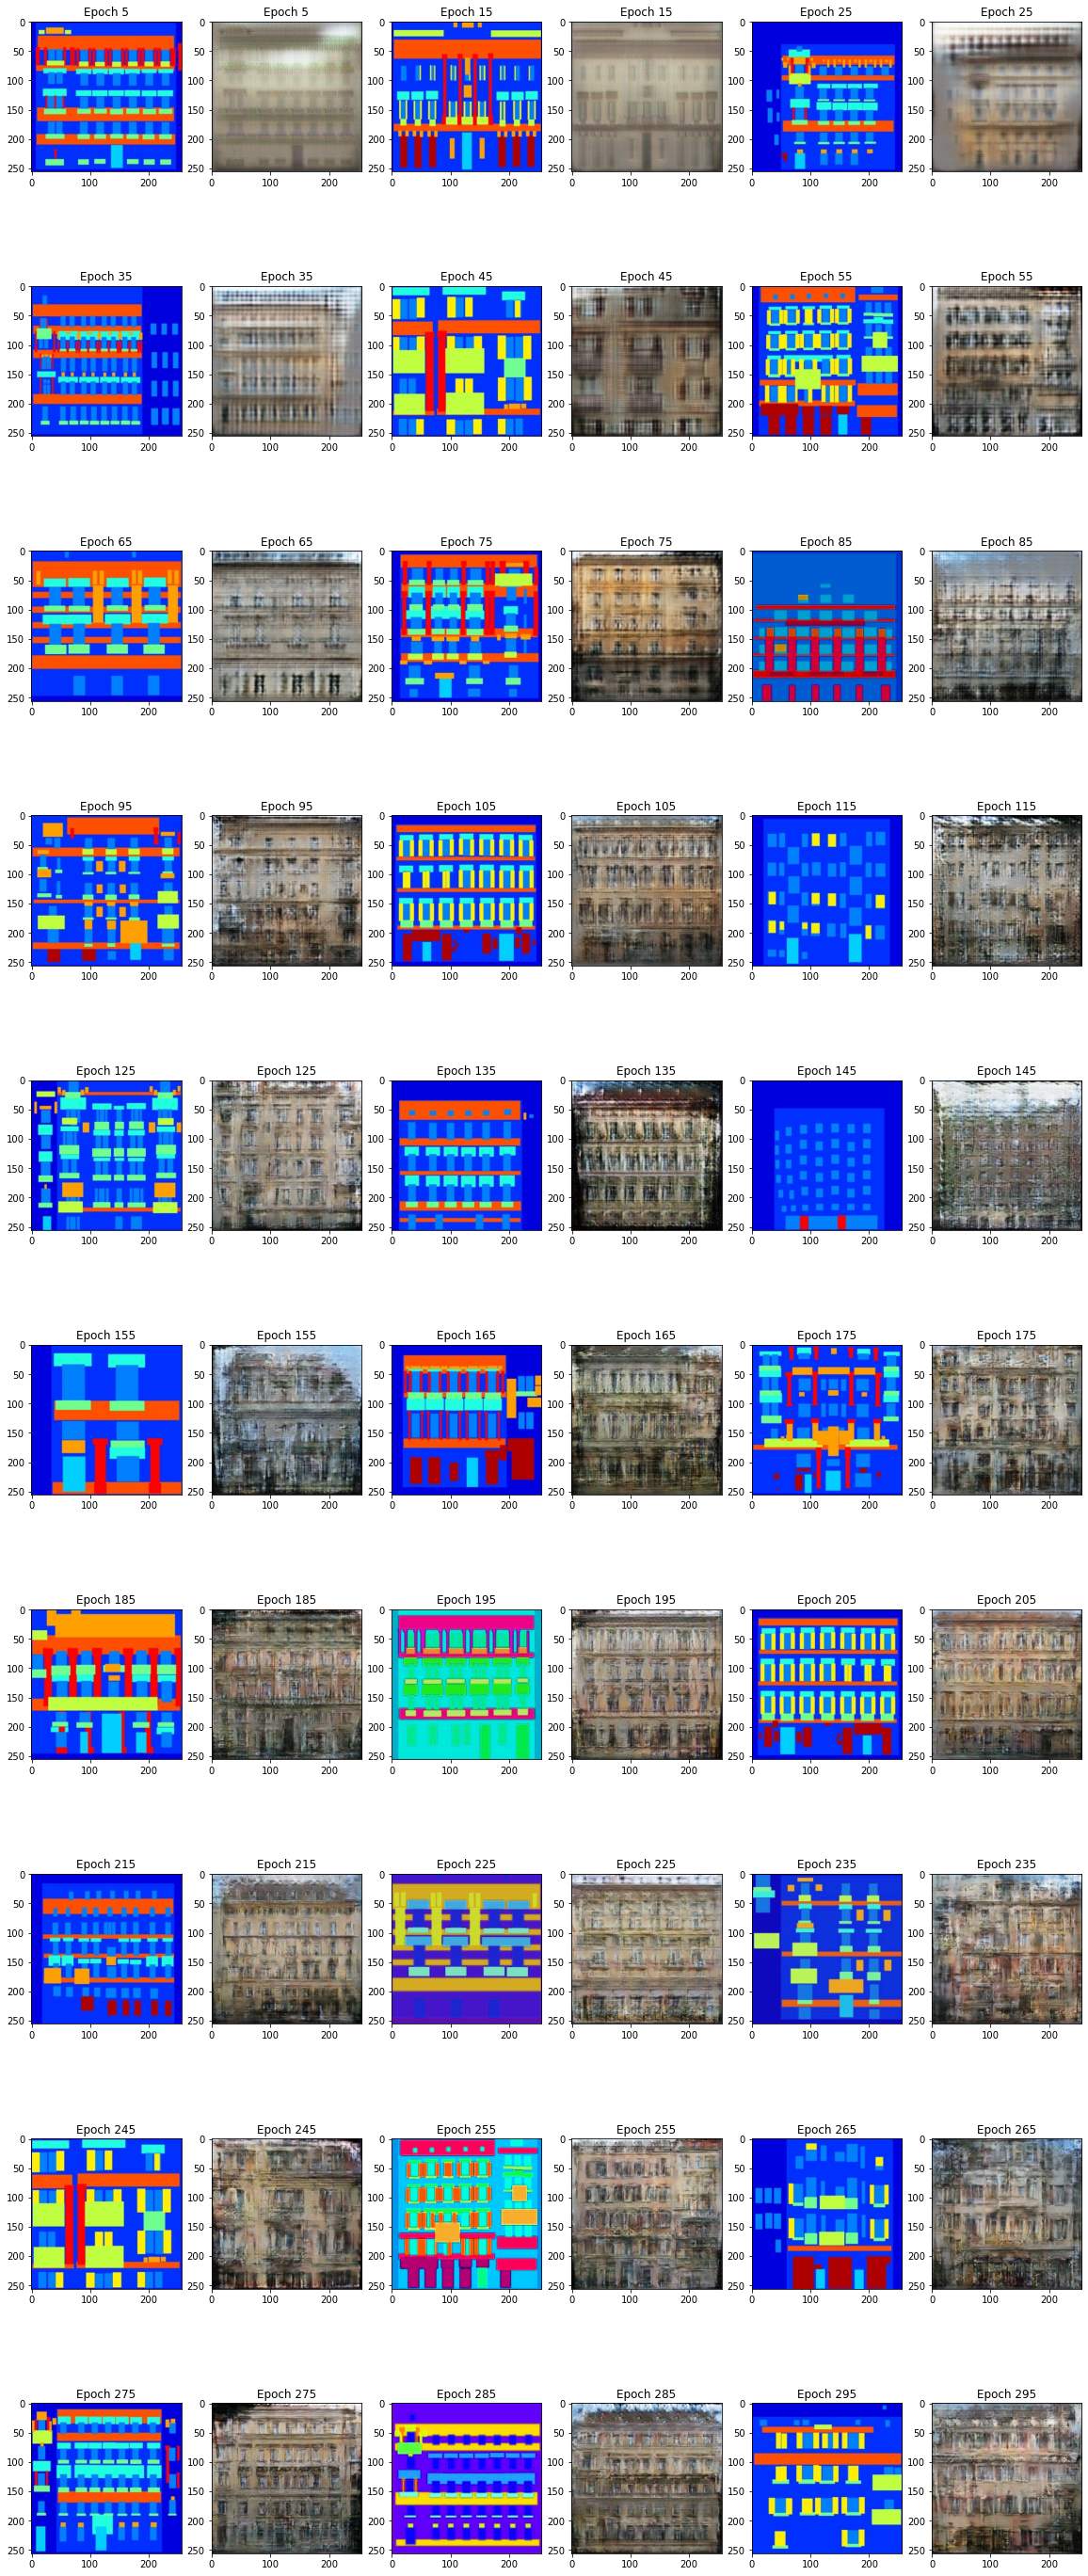

In [11]:
import PIL
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 50))
columns = 6
rows = 10
for i in range(1, columns*rows + 1, 2):
    input_img = PIL.Image.open(f'evaluation_p2p/input_{5*i}.png')
    gen_img = PIL.Image.open(f'evaluation_p2p/y_gen_{5*i}.png') 
    fig.add_subplot(rows, columns, i)
    plt.title(f'Epoch {5*i}')
    plt.imshow(input_img)
    fig.add_subplot(rows, columns, i + 1)
    plt.title(f'Epoch {5*i}')
    plt.imshow(gen_img)

plt.subplots_adjust(hspace=0.5, wspace=0.2)
plt.show()  

## Part 2. CycleGAN.

- two generators and two discriminators: one pair from real one to raw and another pair from raw to real
- additional loss: cycle consistency loss - generate fake real from raw and from the fake real generate fake raw (raw -> fake real -> fake raw)
- identity mapping loss: if real generator gets real image it should produce real image, same way for raw image
- total loss: cycle loss + identity loss + least squares
- architecture: generator has downsampling encoder, residual blocks, and upsampling decoder; discriminator is several downsampling convolutional blocks

In [7]:
# Configurations for CycleGAN

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_DIR = "facades/train"
VAL_DIR = "facades/val"
BATCH_SIZE = 1
LEARNING_RATE = 1e-5
LAMBDA_IDENTITY = 0.0
LAMBDA_CYCLE = 10
NUM_WORKERS = 4
NUM_EPOCHS = 20

In [8]:
def train_cgan(disc_H, disc_Z, gen_Z, gen_H, loader, opt_disc, opt_gen, l1, mse, d_scaler, g_scaler):
    H_reals = 0
    H_fakes = 0
    loop = tqdm(loader, leave=True)

    for idx, (x, y) in enumerate(loop):
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        # Train Discriminators H and Z
        with torch.cuda.amp.autocast():
            fake_y = gen_H(x)
            D_H_real = disc_H(y)
            D_H_fake = disc_H(fake_y.detach())
            H_reals += D_H_real.mean().item()
            H_fakes += D_H_fake.mean().item()
            D_H_real_loss = mse(D_H_real, torch.ones_like(D_H_real))
            D_H_fake_loss = mse(D_H_fake, torch.zeros_like(D_H_fake))
            D_H_loss = D_H_real_loss + D_H_fake_loss

            fake_x = gen_Z(y)
            D_Z_real = disc_Z(x)
            D_Z_fake = disc_Z(fake_x.detach())
            D_Z_real_loss = mse(D_Z_real, torch.ones_like(D_Z_real))
            D_Z_fake_loss = mse(D_Z_fake, torch.zeros_like(D_Z_fake))
            D_Z_loss = D_Z_real_loss + D_Z_fake_loss

            # put it togethor
            D_loss = (D_H_loss + D_Z_loss)/2

        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train Generators H and Z
        with torch.cuda.amp.autocast():
            # adversarial loss for both generators
            D_H_fake = disc_H(fake_y)
            D_Z_fake = disc_Z(fake_x)
            loss_G_H = mse(D_H_fake, torch.ones_like(D_H_fake))
            loss_G_Z = mse(D_Z_fake, torch.ones_like(D_Z_fake))

            # cycle loss
            cycle_x = gen_Z(fake_y)
            cycle_y = gen_H(fake_x)
            cycle_x_loss = l1(x, cycle_x)
            cycle_y_loss = l1(y, cycle_y)

            # identity loss (remove these for efficiency if you set lambda_identity=0)
            identity_x = gen_Z(x)
            identity_y = gen_H(y)
            identity_x_loss = l1(x, identity_x)
            identity_y_loss = l1(y, identity_y)

            # add all togethor
            G_loss = (
                loss_G_Z
                + loss_G_H
                + cycle_x_loss * LAMBDA_CYCLE
                + cycle_y_loss * LAMBDA_CYCLE
                + identity_y_loss * LAMBDA_IDENTITY
                + identity_x_loss * LAMBDA_IDENTITY
            )

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        loop.set_postfix(H_real=H_reals/(idx+1), H_fake=H_fakes/(idx+1))

In [ ]:
# Training

## Models
disc_H = DiscriminatorCGAN(in_channels=3).to(DEVICE)
disc_Z = DiscriminatorCGAN(in_channels=3).to(DEVICE)
gen_Z = GeneratorCGAN(img_channels=3, num_residuals=9).to(DEVICE)
gen_H = GeneratorCGAN(img_channels=3, num_residuals=9).to(DEVICE)

## Optimizers
opt_disc = optim.Adam(list(disc_H.parameters()) + list(disc_Z.parameters()), lr=LEARNING_RATE,betas=(0.5, 0.999))
opt_gen = optim.Adam(list(gen_Z.parameters()) + list(gen_H.parameters()),lr=LEARNING_RATE, betas=(0.5, 0.999))

## Losses
L1 = nn.L1Loss()
mse = nn.MSELoss()

## Dataloaders
train_dataset = FacadesDataset(root_dir=TRAIN_DIR)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True,num_workers=NUM_WORKERS)
val_dataset = FacadesDataset(root_dir=VAL_DIR)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)

## To speed up training
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

## Training
for epoch in range(NUM_EPOCHS):
    train_cgan(disc_H, disc_Z, gen_Z, gen_H, train_loader, opt_disc, opt_gen, L1, mse, d_scaler, g_scaler)
    
    # Save example images
    save_some_examples(gen, val_loader, epoch, folder="evaluation_cyclegan")

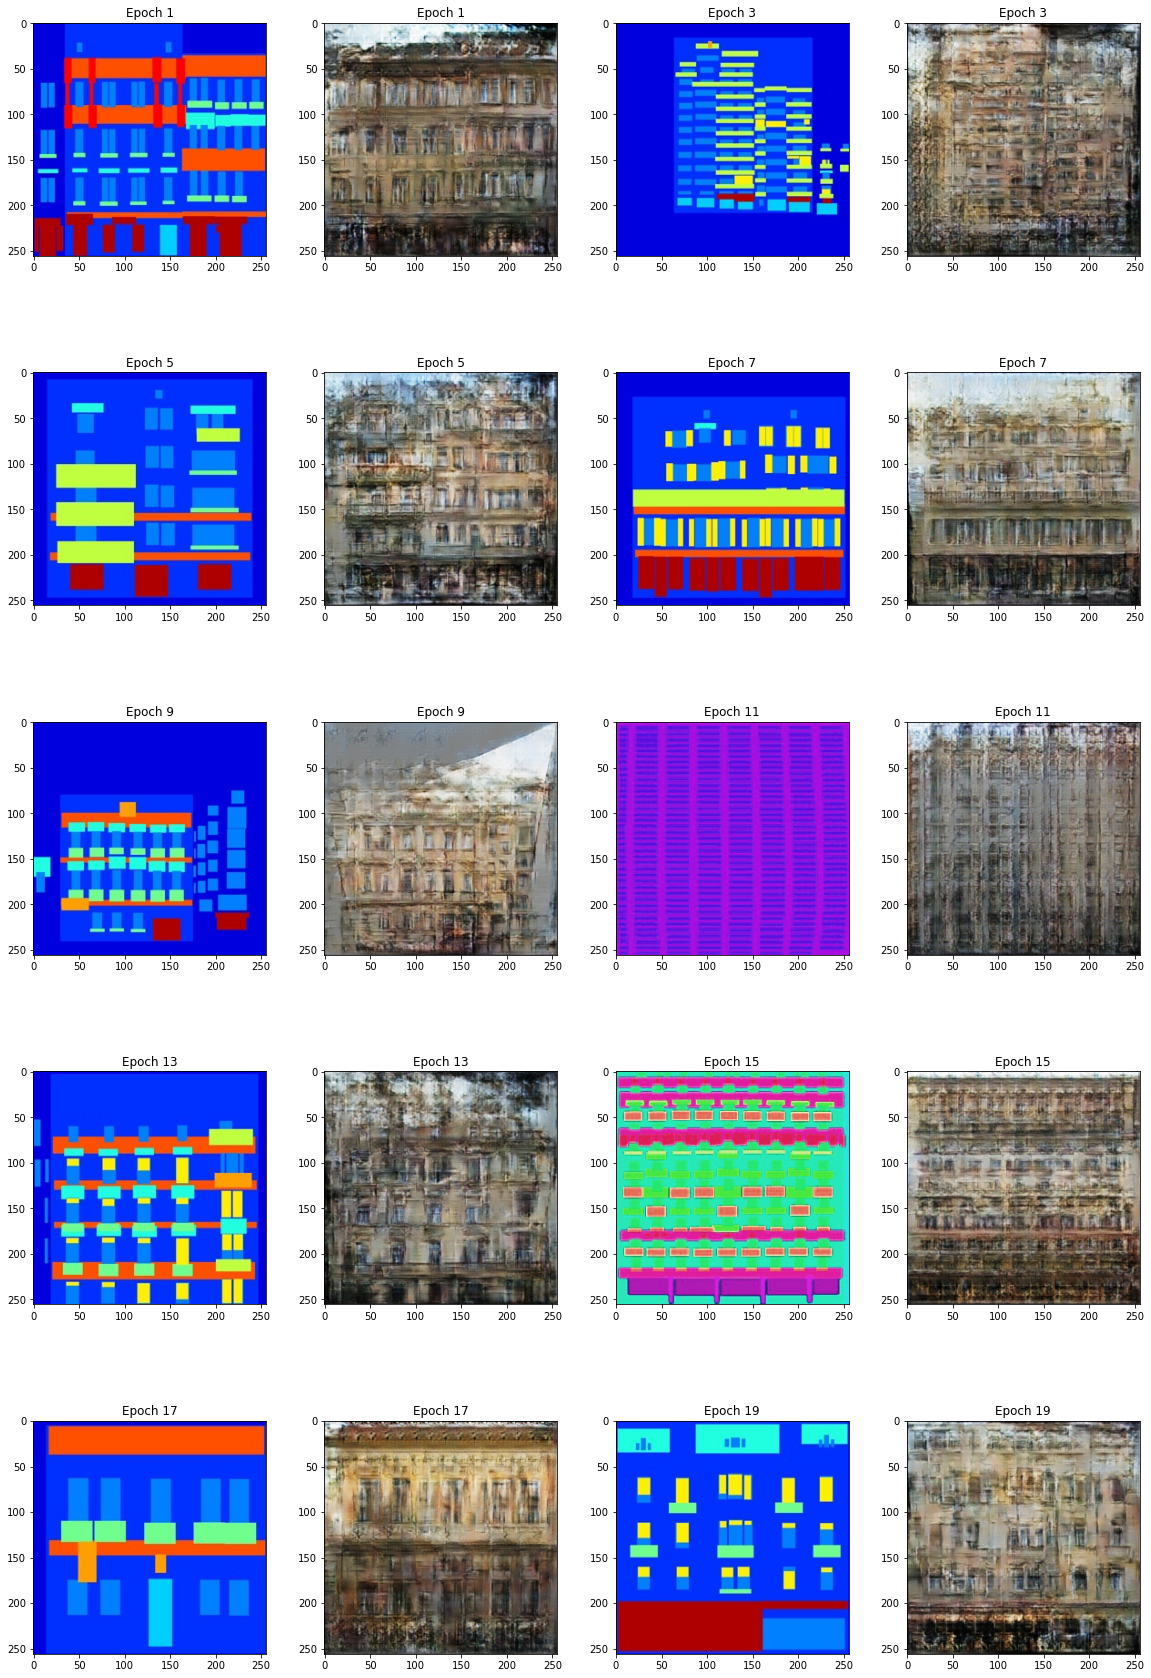

In [13]:
import PIL
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 30))
columns = 4
rows = 5
for i in range(1, columns*rows + 1, 2):
    input_img = PIL.Image.open(f'evaluation_cyclegan/input_{(i-1)}.png')
    gen_img = PIL.Image.open(f'evaluation_cyclegan/y_gen_{(i-1)}.png') 
    fig.add_subplot(rows, columns, i)
    plt.title(f'Epoch {i}')
    plt.imshow(input_img)
    fig.add_subplot(rows, columns, i + 1)
    plt.title(f'Epoch {i}')
    plt.imshow(gen_img)

plt.subplots_adjust(hspace=0.5, wspace=0.2)
plt.show()  

#### Sources
- Pix2Pix: https://www.youtube.com/watch?v=SuddDSqGRzg
- CycleGAN: https://www.youtube.com/watch?v=4LktBHGCNfw